# Spatial heterogeneity control analysis using pretrained models by Rutherford et al. (2021)
[Another pretrained model](https://doi.org/10.7554/eLife.72904) representing regional CTh and SA over the lifespan was used to validate results. Instructions on out-of-sample estimation and corresponding scripts can be found [here](https://colab.research.google.com/github/CharFraza/CPC_ML_tutorial/blob/master/tasks/2_apply_normative_models.ipynb#scrollTo=_5ZET1btKF6J).

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from os.path import join

# define directories
cwd = os.getcwd()
out_dir_main = join(cwd, 'outputs', 'supp_rutherford')
os.makedirs(out_dir_main, exist_ok=True)

# settings 
brain_measure = 'SA'  # CT or SA
refit_model = True  # if True, refit the model; if False, load the precomputed model

In [3]:
# clone original repository containing the braincharts code and models
if not os.path.exists(join(out_dir_main, 'braincharts')) and refit_model:
    print('Cloning repository...')
    os.chdir(out_dir_main)
    ! git clone https://github.com/predictive-clinical-neuroscience/braincharts.git
    os.chdir(cwd)

In [4]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import numpy as np
import pandas as pd
import pickle
from matplotlib import pyplot as plt
import seaborn as sns

from pcntoolkit.normative import estimate, predict, evaluate
from pcntoolkit.util.utils import compute_MSLL, create_design_matrix
os.chdir(join(out_dir_main, 'braincharts', 'scripts'))
from nm_utils import remove_bad_subjects, load_2d
os.chdir(cwd)

# import custom code
import sys
sys.path.append('code')
from spatial_heterogeneity import calc_infra_supra_percentage

# define more directories
mdl_dir = join(out_dir_main, 'braincharts', 'models')

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [5]:
# unzip models used for CT and SA
os.chdir(mdl_dir)
if not os.path.exists(join(mdl_dir, 'lifespan_DK_46K_59sites')):  # if this is the first time running this script
    ! unzip lifespan_DK_46K_59sites.zip
    ! unzip lifespan_sa_DK_46K_59sites.zip
    ! rm *.zip
    ! rm *.tar.gz
    
os.chdir(cwd)

In [6]:
def plot_barplot(x, y1, y2, idp_order, color_theme, title, outname):
    sns.set_style('white')
    
    # combine y1 and y2 into one df
    df = pd.DataFrame({'Supranormal deviation': y1, 'Infranormal deviation': y2, 'ROI': idp_order})
    # Reverse order for bottom-to-top plotting
    df = df.iloc[::-1].reset_index(drop=True)
    
    # Plotting
    fig, ax = plt.subplots(figsize=(6, 16), dpi=50)

    df[['Supranormal deviation', 'Infranormal deviation']].plot(
        kind='barh',
        ax=ax,
        color=color_theme
    )
    
    ax.set_title(title)
    ax.set_ylabel('')
    yticks = [i.split('_')[1] + ' ' + i.split('_')[2] for i in df['ROI']]
    ax.set_yticklabels(yticks)
    ax.set_xlabel('Subjects with extranormal deviations [%]')
    
    plt.tight_layout()
    sns.despine()
    plt.savefig(outname)
    plt.show()
    return df

# Load pretrained model
Load and extract the pretrained model by Rutherford and colleagues.

In [7]:
# which model do we wish to use?
if brain_measure == 'CT':
    model_name = 'lifespan_DK_46K_59sites'
    site_names = 'site_ids_ct_dk_59sites.txt'
    phenotype_names_lh = 'phenotypes_ct_dk_lh.txt'
    phenotype_names_rh = 'phenotypes_ct_dk_rh.txt'
elif brain_measure == 'SA':
    model_name = 'lifespan_sa_DK_46K_59sites'
    site_names = 'site_ids_ct_dk_59sites.txt'  # assumed that it is same as CT
    phenotype_names_lh = 'phenotypes_sa_dk_lh.txt'
    phenotype_names_rh = 'phenotypes_sa_dk_rh.txt'

# where the analysis takes place
out_dir = join(mdl_dir, model_name)

In [8]:
# load a set of site ids from this model. This must match the training data
with open(join(out_dir_main, 'braincharts', 'docs', site_names)) as f:
    site_ids_tr = f.read().splitlines()

# Model adaptation
This will make predictions for each IDP separately. As training of the model did not involve the BLS dataset, the model has to be adapted to this specific dataset. We use the term-born ('CN') subjects for this purpose, the `adaptation set`. 
Next, deviation scores are calculated for the `test`or `application set`, the preterm subjects.

In [9]:
# load raw data from BLS-26 cohort (combined FreeSurfer output after QC)
bls_26 = pd.read_csv(join(cwd, 'data', 'BLS', 'derivatives', f'BLS-26_{brain_measure}_raw.csv'))
bls_26.rename(columns={'age': 'Age', 'Scanner_ID': 'scanner'}, inplace=True)
bls_26['site'] = 'BLS' + bls_26['scanner'].astype(str)
bls_26['sex_code_fem'] = (bls_26['sex'] == 'female').astype(int)
bls_26['dx'] = bls_26['phenotype'].map({'term': 'CN', 'preterm': 'preterm'})


# drop columns
bls_26 = bls_26.drop(columns=['blsgroup', 'phenotype', 'sex_code'])

In [10]:
# split adaptation and test set 
df_ad = bls_26[bls_26['dx']=='CN']
df_ad.reset_index(drop=True, inplace=True)
df_ad.to_csv(os.path.join(out_dir_main, f'BLS-26_{brain_measure}_adaptation_data.csv'))
print(f'{df_ad.shape[0]} subjects in adaptation set')

df_te = bls_26[bls_26['dx']=='preterm']
df_te.reset_index(drop=True, inplace=True)
df_te.to_csv(os.path.join(out_dir_main, f'BLS-26_{brain_measure}_application_data_preterm.csv'))
print(f'{df_te.shape[0]} subjects in test set')

107 subjects in adaptation set
96 subjects in test set


In [11]:
# extract a list of unique site ids from the sets
site_ids_ad =  sorted(set(df_ad['site'].to_list()))
site_ids_te =  sorted(set(df_te['site'].to_list()))

## Configure which models to fit

In [12]:
# load all available phenotypes
os.chdir(mdl_dir)
with open(join(out_dir_main, 'braincharts', 'docs', phenotype_names_lh)) as f:
    idp_ids_lh = f.read().splitlines()
with open(join(out_dir_main, 'braincharts', 'docs', phenotype_names_rh)) as f:
    idp_ids_rh = f.read().splitlines()
    
idp_ids = idp_ids_lh + idp_ids_rh 

## Covariates and model fitting
Model fitting will take about 30-60 minutes depending on your machine.

In [13]:
# which data columns do we wish to use as covariates?
cols_cov = ['Age','sex_code_fem']

# limits for cubic B-spline basis
xmin = -5
xmax = 110

# Absolute Z treshold above which a sample is considered to be an outlier (without fitting any model)
outlier_thresh = 7

In [14]:
os.chdir(cwd)

In [15]:
for idp_num, idp in enumerate(idp_ids):
    print('Running IDP', idp_num, idp, ':')
    idp_dir = os.path.join(out_dir, idp)
    os.chdir(idp_dir)

    # extract and save the response variables for the test set
    y_te = df_te[idp].to_numpy()

    # save the variables
    resp_file_te = os.path.join(idp_dir, 'resp_te.txt')
    np.savetxt(resp_file_te, y_te)

    # configure and save the design matrix
    cov_file_te = os.path.join(idp_dir, 'cov_bspline_te.txt')
    X_te = create_design_matrix(df_te[cols_cov],
                                site_ids = df_te['site'],
                                all_sites = site_ids_tr,
                                basis = 'bspline',
                                xmin = xmin,
                                xmax = xmax)
    np.savetxt(cov_file_te, X_te)

    # check whether all sites in the test set are represented in the training set
    if all(elem in site_ids_tr for elem in site_ids_te):
        print('All sites are present in the training data')

        # just make predictions
        yhat_te, s2_te, Z = predict(cov_file_te,
                                    alg='blr',
                                    respfile=resp_file_te,
                                    model_path=os.path.join(idp_dir,'Models'))
    else:
        print('Some sites missing from the training data. Adapting model')

        # save the covariates for the adaptation data
        X_ad = create_design_matrix(df_ad[cols_cov],
                                    site_ids = df_ad['site'],
                                    all_sites = site_ids_tr,
                                    basis = 'bspline',
                                    xmin = xmin,
                                    xmax = xmax)
        cov_file_ad = os.path.join(idp_dir, 'cov_bspline_ad.txt')
        np.savetxt(cov_file_ad, X_ad)

        # save the responses for the adaptation data
        resp_file_ad = os.path.join(idp_dir, 'resp_ad.txt')
        y_ad = df_ad[idp].to_numpy()
        np.savetxt(resp_file_ad, y_ad)

        # save the site ids for the adaptation data
        sitenum_file_ad = os.path.join(idp_dir, 'sitenum_ad.txt')
        site_num_ad = df_ad['scanner'].to_numpy(dtype=int)
        np.savetxt(sitenum_file_ad, site_num_ad)

        # save the site ids for the test data
        sitenum_file_te = os.path.join(idp_dir, 'sitenum_te.txt')
        site_num_te = df_te['scanner'].to_numpy(dtype=int)
        np.savetxt(sitenum_file_te, site_num_te)

        yhat_te, s2_te, Z = predict(cov_file_te,
                                    alg = 'blr',
                                    respfile = resp_file_te,
                                    model_path = os.path.join(idp_dir,'Models'),
                                    adaptrespfile = resp_file_ad,
                                    adaptcovfile = cov_file_ad,
                                    adaptvargroupfile = sitenum_file_ad,
                                    testvargroupfile = sitenum_file_te)
        
# also make predictions for application set (i.e., HC of BLS)
        suffix = 'adaptation'
        predict(cov_file_ad, 
                alg='blr', 
                respfile=resp_file_ad, 
                model_path=os.path.join(idp_dir,'Models'),
                outputsuffix=suffix)

Running IDP 0 L_bankssts :
Some sites missing from the training data. Adapting model
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
Running IDP 1 L_caudalanteriorcingulate :
Some sites missing from the training data. Adapting model
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
Running IDP 2 L_caudalmiddlefrontal :
Some sites missing from the training data. Adapting model
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing

In [16]:
# which sex do we want to plot?
sex = 0 # 1 = male 0 = female
if sex == 1:
    clr = 'blue'
else:
    clr = 'red'

# create dummy data for visualisation
print('configuring dummy data ...')
xx = np.arange(xmin, xmax, 0.5)
X0_dummy = np.zeros((len(xx), 2))
X0_dummy[:,0] = xx
X0_dummy[:,1] = sex

# create the design matrix
X_dummy = create_design_matrix(X0_dummy, xmin=xmin, xmax=xmax, site_ids=None, all_sites=site_ids_tr)

# save the dummy covariates
cov_file_dummy = os.path.join(out_dir,'cov_bspline_dummy_mean.txt')
np.savetxt(cov_file_dummy, X_dummy)

configuring dummy data ...


Running IDP 0 L_bankssts :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([218.1260245]), 'Rho': array([-0.23325868]), 'pRho': array([0.02192592]), 'SMSE': array([1.51612321]), 'EXPV': array([-0.27004465])}


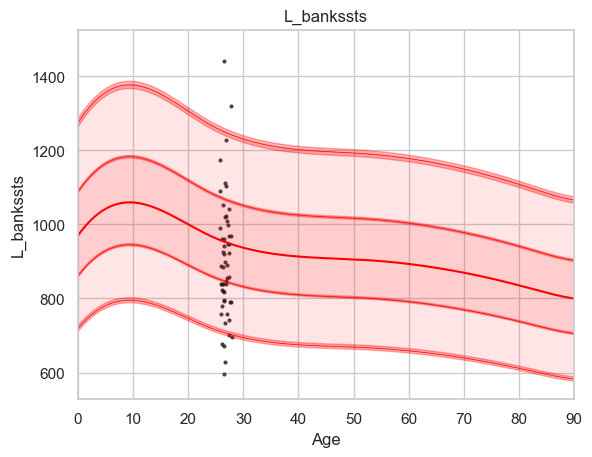

Running IDP 1 L_caudalanteriorcingulate :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([167.00993987]), 'Rho': array([-0.23082101]), 'pRho': array([0.02340227]), 'SMSE': array([1.13797253]), 'EXPV': array([-0.12905324])}


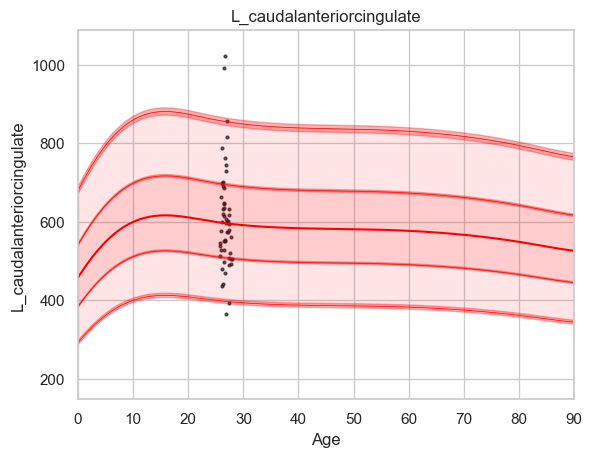

Running IDP 2 L_caudalmiddlefrontal :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([415.80713076]), 'Rho': array([-0.22461784]), 'pRho': array([0.02754477]), 'SMSE': array([1.37337682]), 'EXPV': array([-0.27869874])}


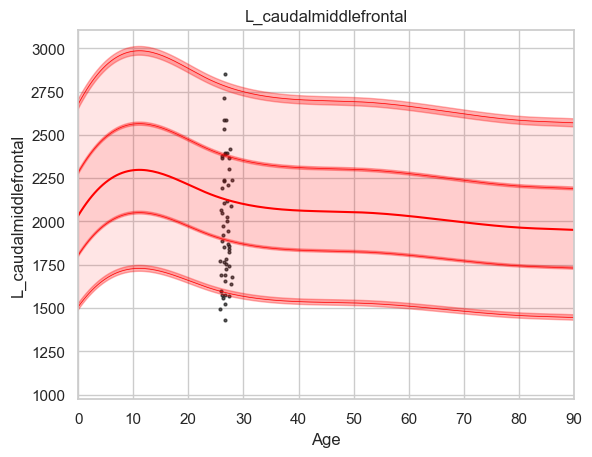

Running IDP 3 L_cuneus :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([267.98592289]), 'Rho': array([-0.3906833]), 'pRho': array([6.91970865e-05]), 'SMSE': array([1.47461093]), 'EXPV': array([-0.36713129])}


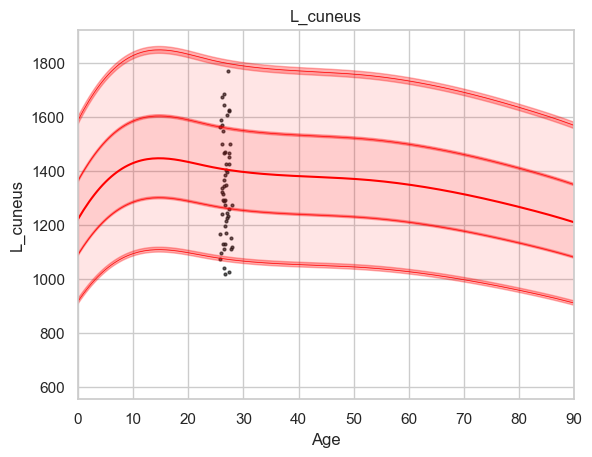

Running IDP 4 L_entorhinal :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([123.7155662]), 'Rho': array([-0.15344087]), 'pRho': array([0.13582765]), 'SMSE': array([1.17817164]), 'EXPV': array([-0.14605212])}


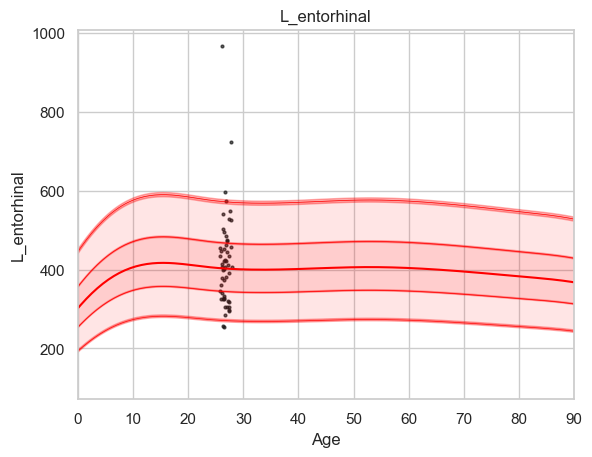

Running IDP 5 L_fusiform :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([472.05113559]), 'Rho': array([-0.41516778]), 'pRho': array([2.03566363e-05]), 'SMSE': array([2.16469952]), 'EXPV': array([-0.88963523])}


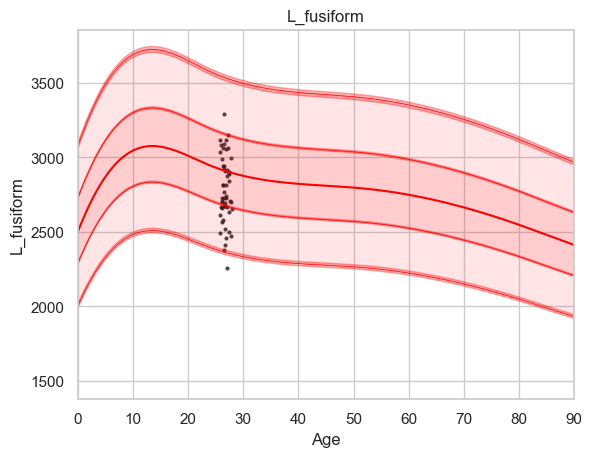

Running IDP 6 L_inferiorparietal :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([828.30844076]), 'Rho': array([-0.12885681]), 'pRho': array([0.21144677]), 'SMSE': array([1.62030213]), 'EXPV': array([-0.37461697])}


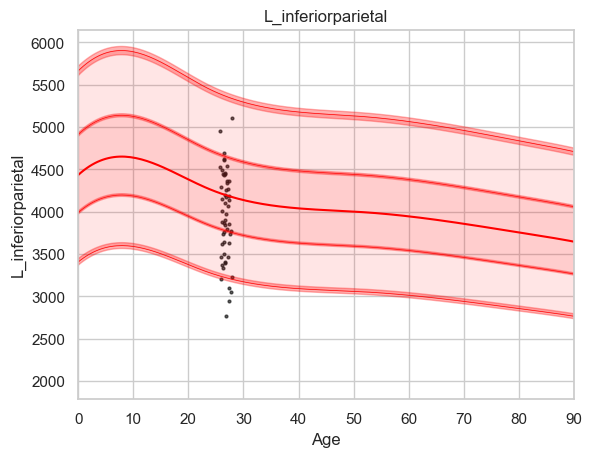

Running IDP 7 L_inferiortemporal :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([674.58385078]), 'Rho': array([-0.30405734]), 'pRho': array([0.00246215]), 'SMSE': array([1.53356022]), 'EXPV': array([-0.51258693])}


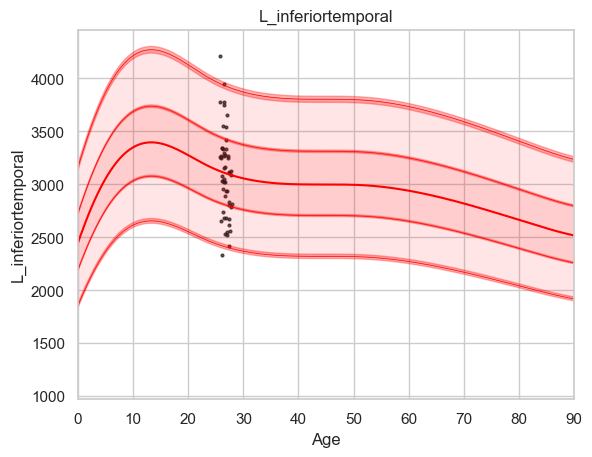

Running IDP 8 L_isthmuscingulate :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([234.3937377]), 'Rho': array([-0.39356624]), 'pRho': array([6.02362354e-05]), 'SMSE': array([1.77694001]), 'EXPV': array([-0.50364674])}


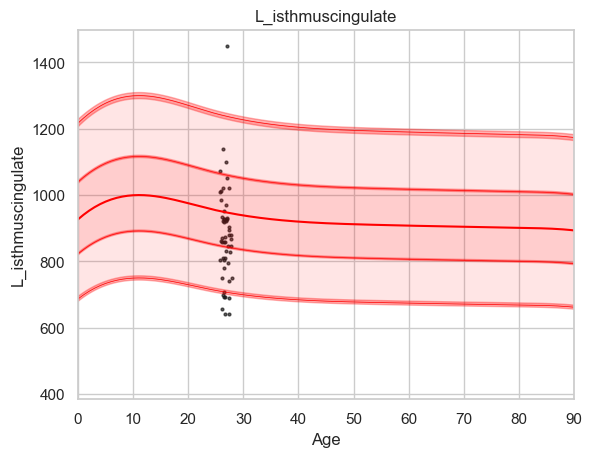

Running IDP 9 L_lateraloccipital :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([842.18123916]), 'Rho': array([-0.45741905]), 'pRho': array([1.89441082e-06]), 'SMSE': array([1.59886275]), 'EXPV': array([-0.58917952])}


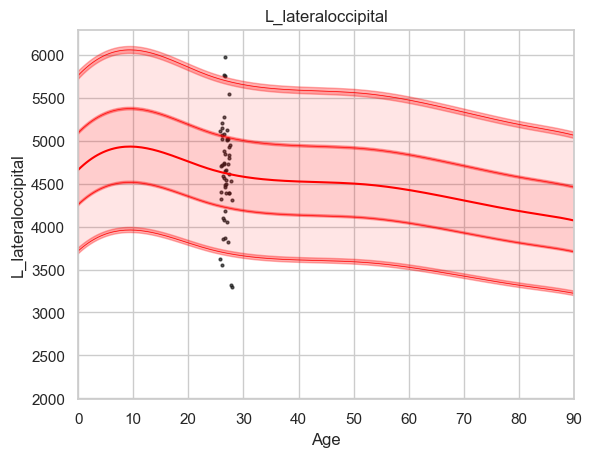

Running IDP 10 L_lateralorbitofrontal :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([417.40337877]), 'Rho': array([-0.28572168]), 'pRho': array([0.00459287]), 'SMSE': array([1.80150661]), 'EXPV': array([-0.39982273])}


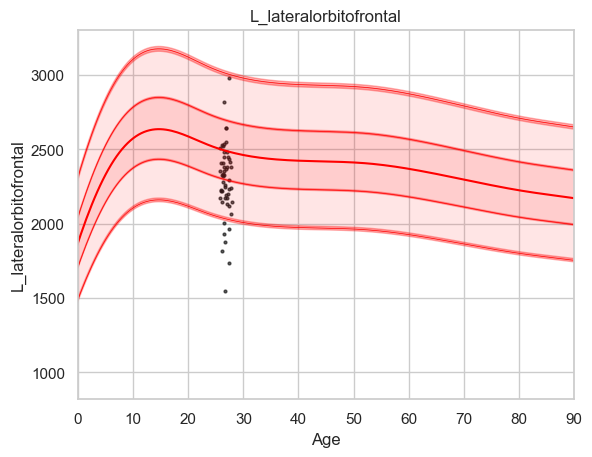

Running IDP 11 L_lingual :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([507.31861642]), 'Rho': array([-0.25507841]), 'pRho': array([0.01188898]), 'SMSE': array([1.38510762]), 'EXPV': array([-0.26223876])}


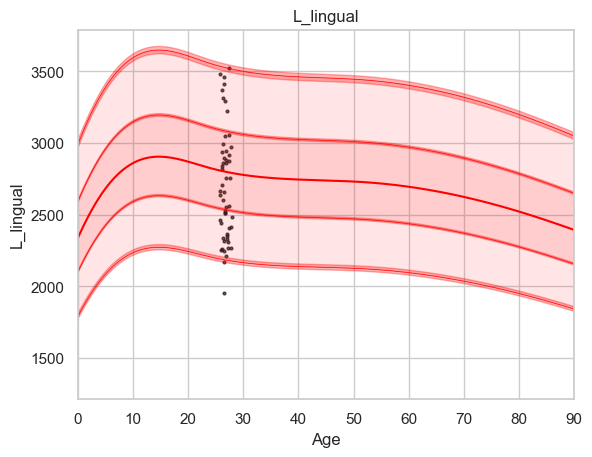

Running IDP 12 L_medialorbitofrontal :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([299.16472525]), 'Rho': array([-0.33665838]), 'pRho': array([0.00072921]), 'SMSE': array([1.66074187]), 'EXPV': array([-0.55646631])}


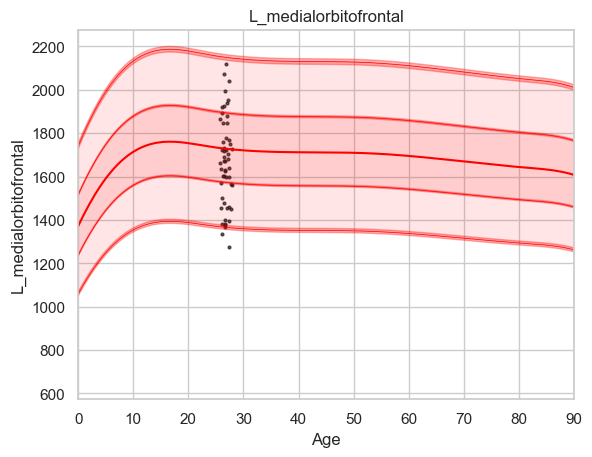

Running IDP 13 L_middletemporal :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([603.87392731]), 'Rho': array([-0.32345657]), 'pRho': array([0.00121442]), 'SMSE': array([1.80160068]), 'EXPV': array([-0.53899907])}


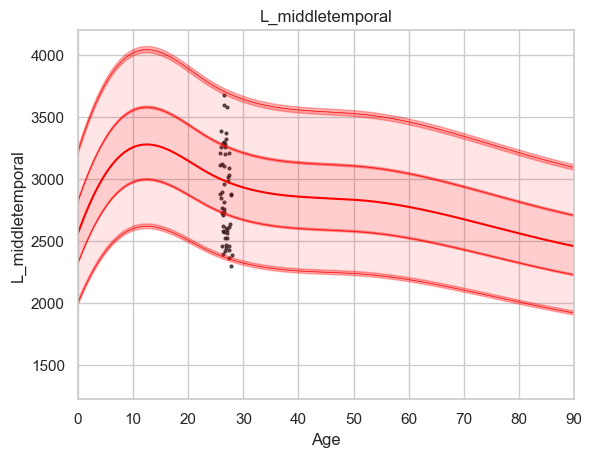

Running IDP 14 L_parahippocampal :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([113.21681392]), 'Rho': array([-0.21270638]), 'pRho': array([0.03724486]), 'SMSE': array([1.1807303]), 'EXPV': array([-0.14767171])}


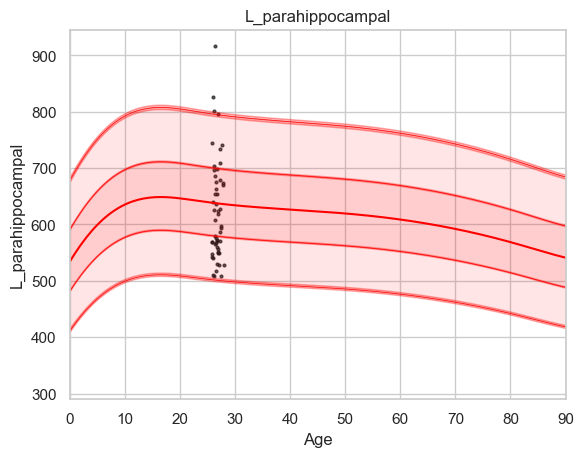

Running IDP 15 L_paracentral :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([216.86421733]), 'Rho': array([-0.43589527]), 'pRho': array([6.63572457e-06]), 'SMSE': array([1.61052885]), 'EXPV': array([-0.44354024])}


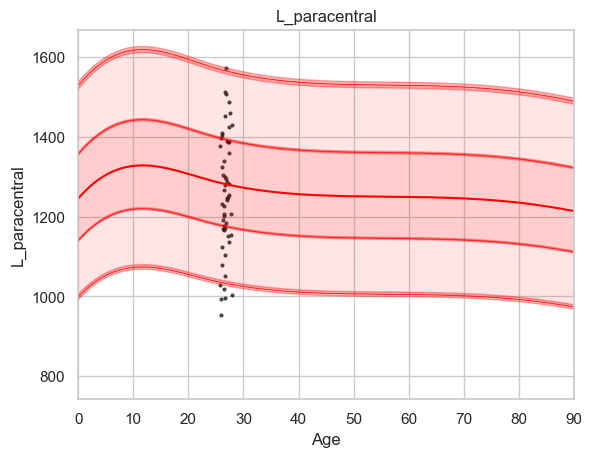

Running IDP 16 L_parsopercularis :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([343.17424204]), 'Rho': array([-0.25122705]), 'pRho': array([0.0132961]), 'SMSE': array([1.20436479]), 'EXPV': array([-0.20316735])}


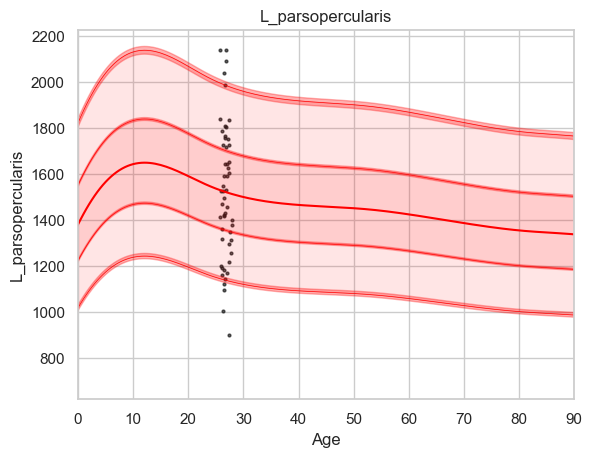

Running IDP 17 L_parsorbitalis :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([120.6878746]), 'Rho': array([-0.32240799]), 'pRho': array([0.00126333]), 'SMSE': array([1.45335931]), 'EXPV': array([-0.40361458])}


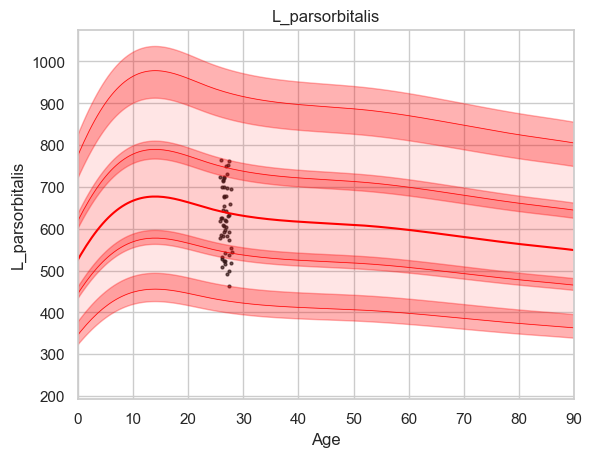

Running IDP 18 L_parstriangularis :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([276.53407085]), 'Rho': array([-0.42011052]), 'pRho': array([1.56965383e-05]), 'SMSE': array([1.40628632]), 'EXPV': array([-0.34681449])}


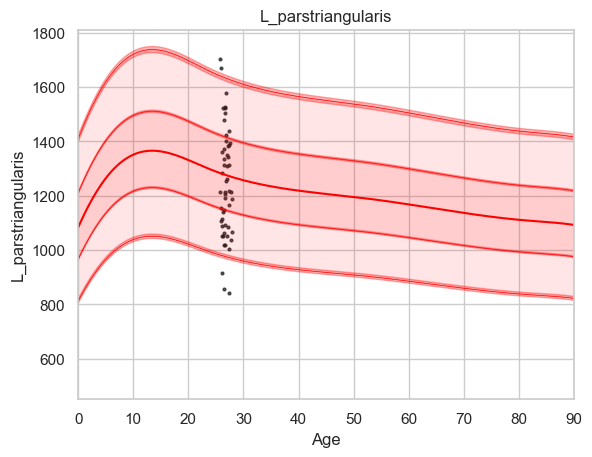

Running IDP 19 L_pericalcarine :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([282.37810525]), 'Rho': array([-0.14208128]), 'pRho': array([0.16773584]), 'SMSE': array([1.21844579]), 'EXPV': array([-0.11797054])}


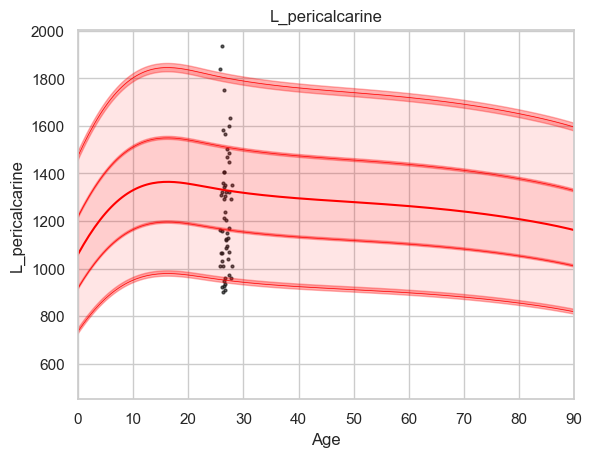

Running IDP 20 L_postcentral :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([651.25960147]), 'Rho': array([-0.52445936]), 'pRho': array([1.94132298e-08]), 'SMSE': array([1.89676215]), 'EXPV': array([-0.75883419])}


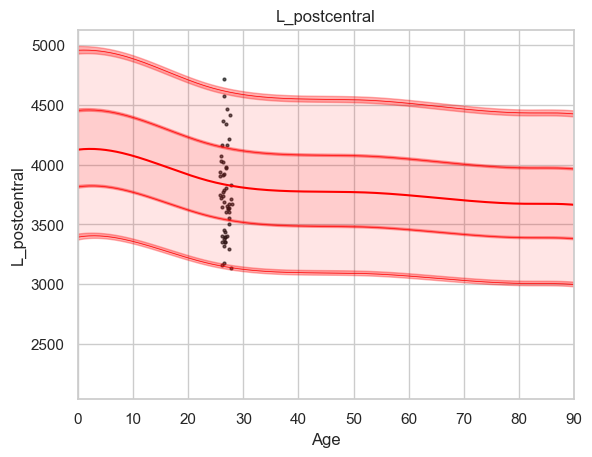

Running IDP 21 L_posteriorcingulate :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([248.83578426]), 'Rho': array([-0.27378509]), 'pRho': array([0.00674062]), 'SMSE': array([1.39705611]), 'EXPV': array([-0.28127187])}


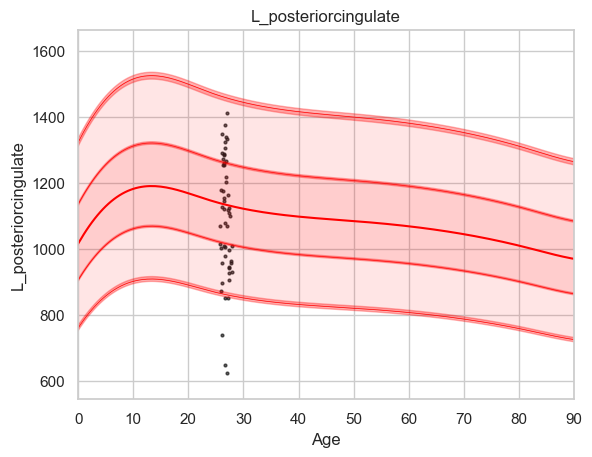

Running IDP 22 L_precentral :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([744.55795783]), 'Rho': array([-0.46928038]), 'pRho': array([9.10593547e-07]), 'SMSE': array([1.72252867]), 'EXPV': array([-0.62981371])}


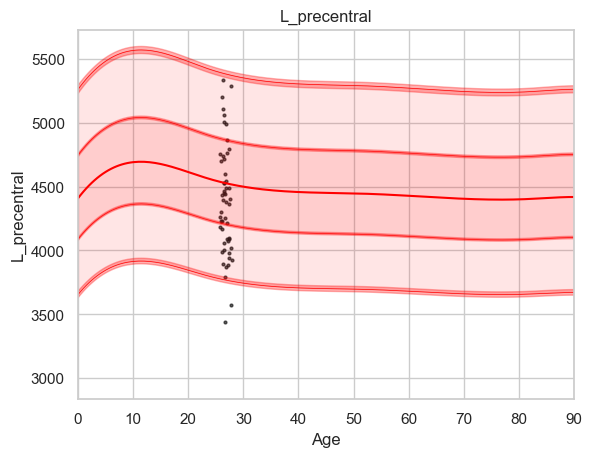

Running IDP 23 L_precuneus :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([680.3958227]), 'Rho': array([-0.50753225]), 'pRho': array([6.86534486e-08]), 'SMSE': array([1.74590515]), 'EXPV': array([-0.71653963])}


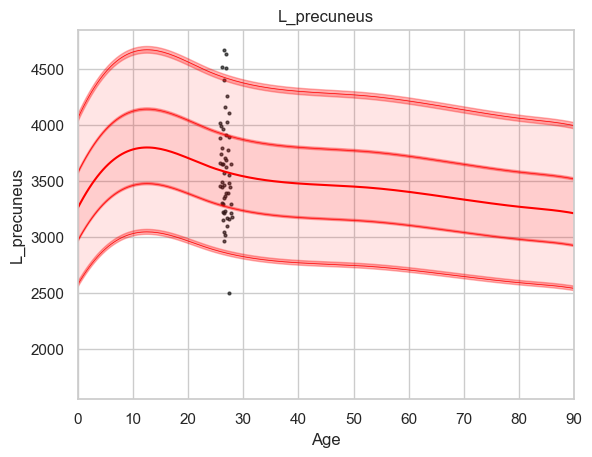

Running IDP 24 L_rostralanteriorcingulate :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([215.19117907]), 'Rho': array([-0.46996959]), 'pRho': array([8.71814926e-07]), 'SMSE': array([1.66309144]), 'EXPV': array([-0.52017045])}


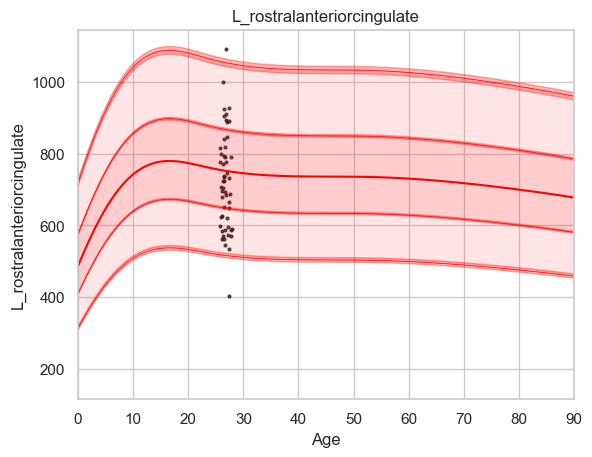

Running IDP 25 L_rostralmiddlefrontal :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([1167.37153814]), 'Rho': array([-0.5285763]), 'pRho': array([1.4107332e-08]), 'SMSE': array([1.61426681]), 'EXPV': array([-0.61219355])}


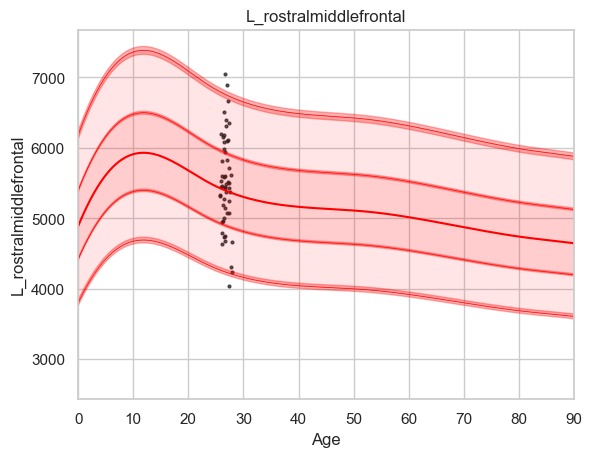

Running IDP 26 L_superiorfrontal :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([1251.8413213]), 'Rho': array([-0.53248254]), 'pRho': array([1.03734163e-08]), 'SMSE': array([1.90463319]), 'EXPV': array([-0.76911891])}


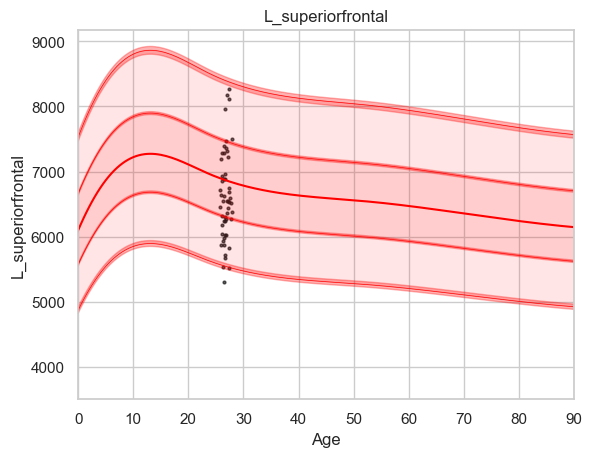

Running IDP 27 L_superiorparietal :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([879.59495519]), 'Rho': array([-0.28787572]), 'pRho': array([0.00427778]), 'SMSE': array([1.70924689]), 'EXPV': array([-0.48452074])}


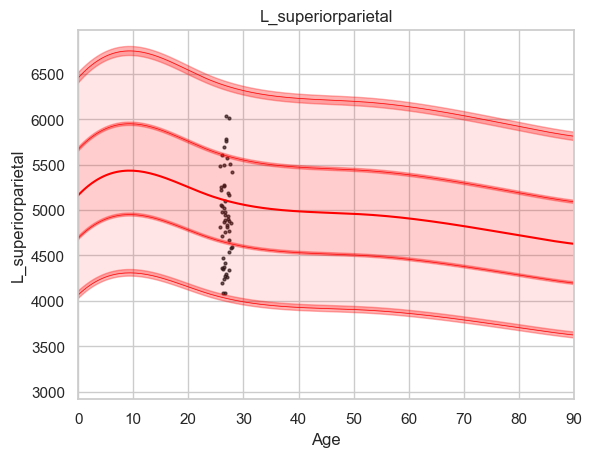

Running IDP 28 L_superiortemporal :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([567.9669066]), 'Rho': array([-0.36378506]), 'pRho': array([0.0002364]), 'SMSE': array([1.6675719]), 'EXPV': array([-0.64364639])}


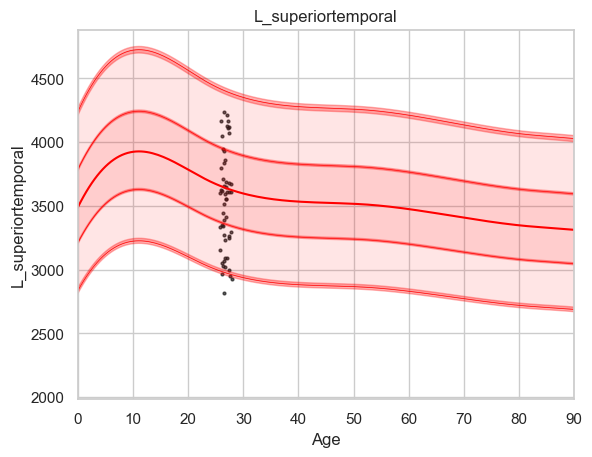

Running IDP 29 L_supramarginal :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([914.17134194]), 'Rho': array([-0.45275894]), 'pRho': array([2.5053421e-06]), 'SMSE': array([1.62999266]), 'EXPV': array([-0.55865222])}


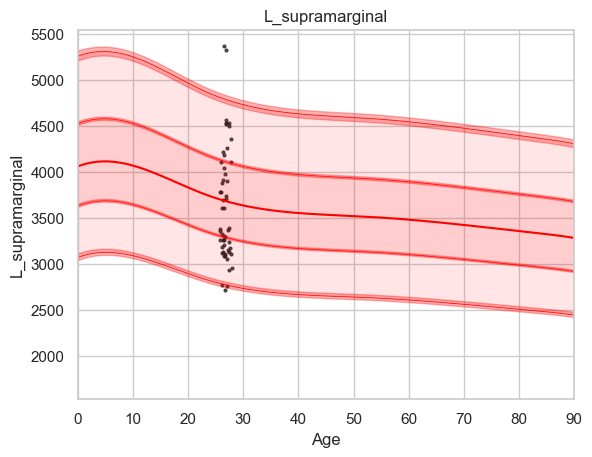

Running IDP 30 L_frontalpole :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([39.35394063]), 'Rho': array([-0.18813973]), 'pRho': array([0.066324]), 'SMSE': array([1.27767894]), 'EXPV': array([-0.27723439])}


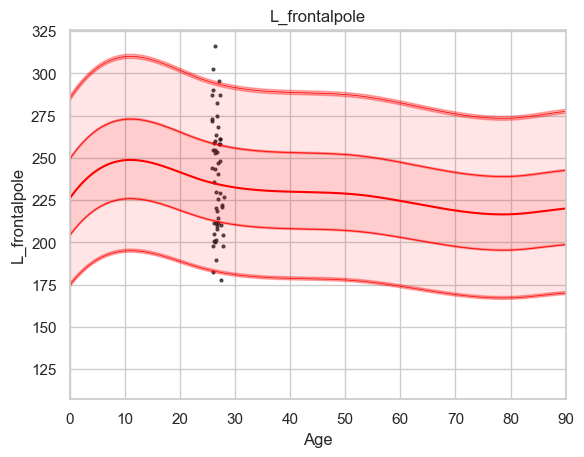

Running IDP 31 L_temporalpole :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([87.95376174]), 'Rho': array([-0.43402658]), 'pRho': array([7.36615888e-06]), 'SMSE': array([1.36246264]), 'EXPV': array([-0.35298943])}


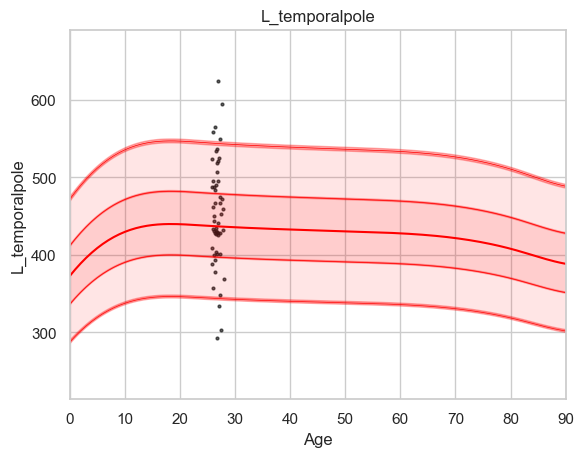

Running IDP 32 L_transversetemporal :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([79.1006255]), 'Rho': array([-0.28586456]), 'pRho': array([0.00457135]), 'SMSE': array([1.34869887]), 'EXPV': array([-0.32830567])}


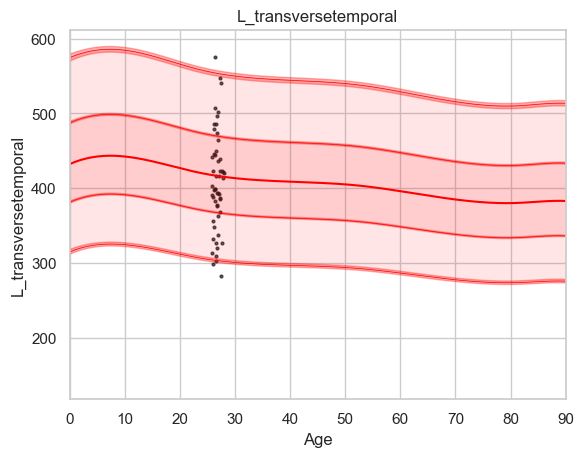

Running IDP 33 L_insula :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([347.55675053]), 'Rho': array([-0.45580554]), 'pRho': array([2.08800249e-06]), 'SMSE': array([1.6265142]), 'EXPV': array([-0.58120469])}


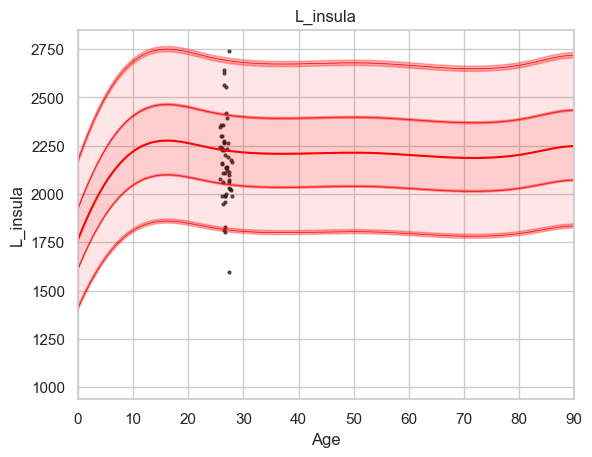

Running IDP 34 R_bankssts :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([180.89171754]), 'Rho': array([-0.27985472]), 'pRho': array([0.00555788]), 'SMSE': array([1.50428232]), 'EXPV': array([-0.22164871])}


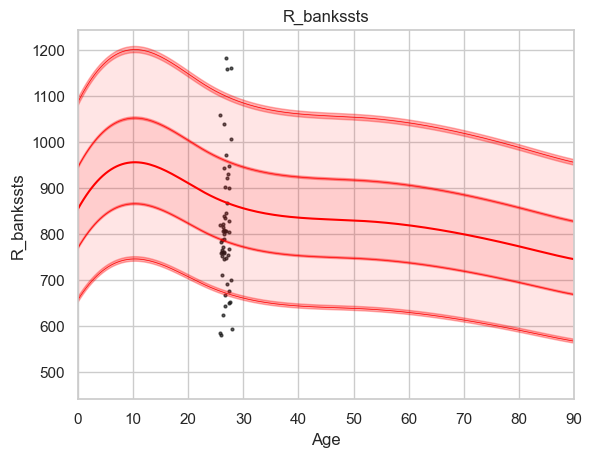

Running IDP 35 R_caudalanteriorcingulate :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([165.5539302]), 'Rho': array([-0.28175575]), 'pRho': array([0.00522722]), 'SMSE': array([1.33882567]), 'EXPV': array([-0.21688744])}


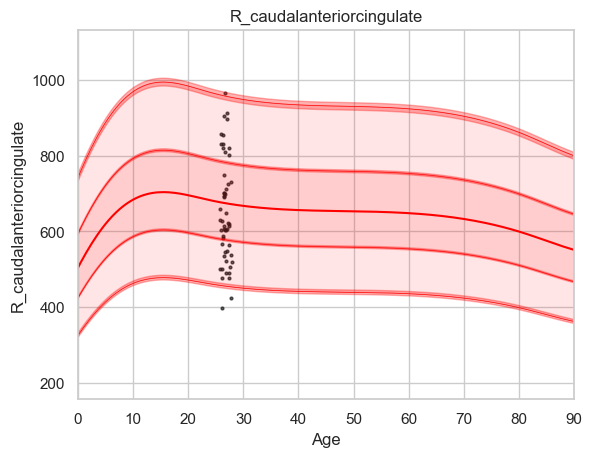

Running IDP 36 R_caudalmiddlefrontal :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([396.86632397]), 'Rho': array([-0.27684749]), 'pRho': array([0.00611875]), 'SMSE': array([1.27826621]), 'EXPV': array([-0.27789855])}


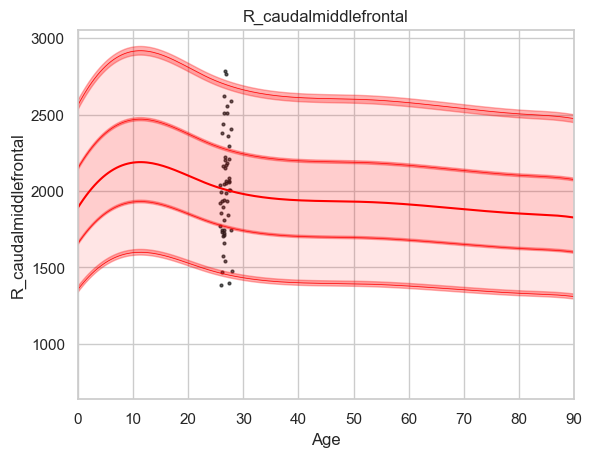

Running IDP 37 R_cuneus :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([296.37473608]), 'Rho': array([-0.35857143]), 'pRho': array([0.00029604]), 'SMSE': array([1.50284616]), 'EXPV': array([-0.45385214])}


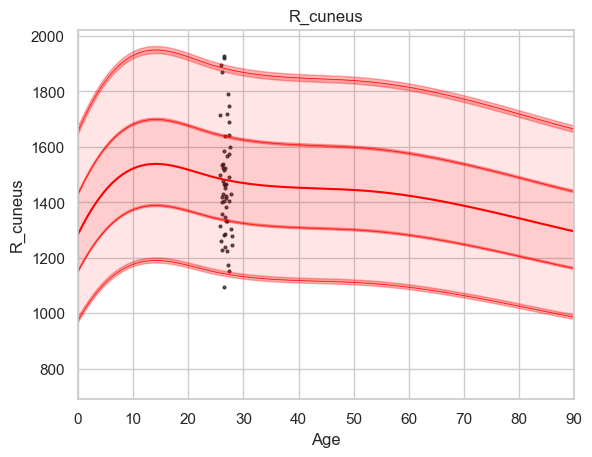

Running IDP 38 R_entorhinal :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([118.97399966]), 'Rho': array([-0.34652528]), 'pRho': array([0.00049016]), 'SMSE': array([1.26386252]), 'EXPV': array([-0.21061556])}


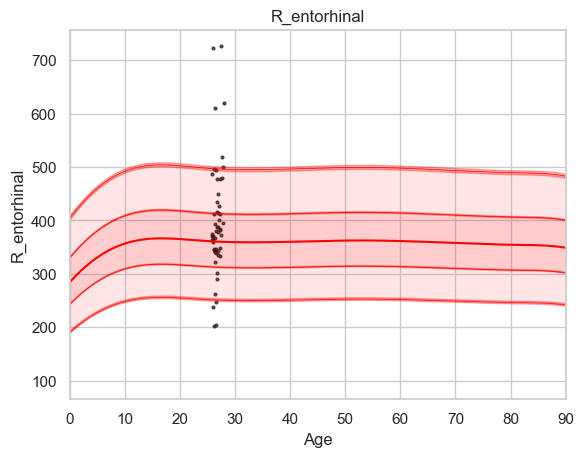

Running IDP 39 R_fusiform :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([601.51308008]), 'Rho': array([-0.47365838]), 'pRho': array([6.89408058e-07]), 'SMSE': array([1.82318085]), 'EXPV': array([-0.71657699])}


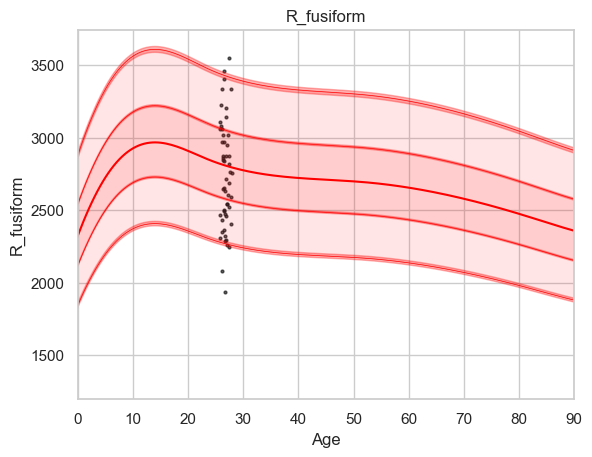

Running IDP 40 R_inferiorparietal :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([1134.18737246]), 'Rho': array([-0.38562018]), 'pRho': array([8.79843907e-05]), 'SMSE': array([1.64917228]), 'EXPV': array([-0.49477709])}


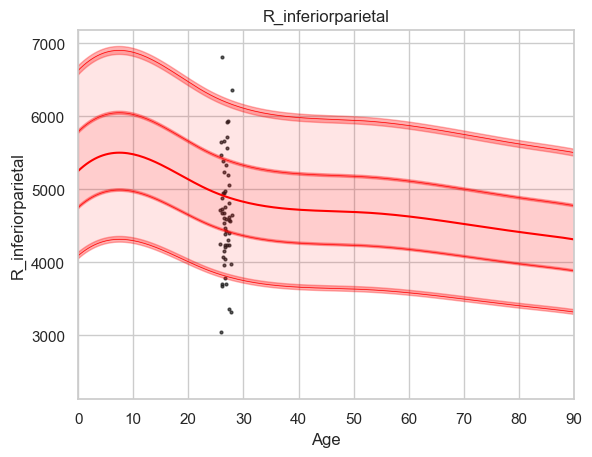

Running IDP 41 R_inferiortemporal :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([636.45038483]), 'Rho': array([-0.4417581]), 'pRho': array([4.76051395e-06]), 'SMSE': array([1.67465091]), 'EXPV': array([-0.67464759])}


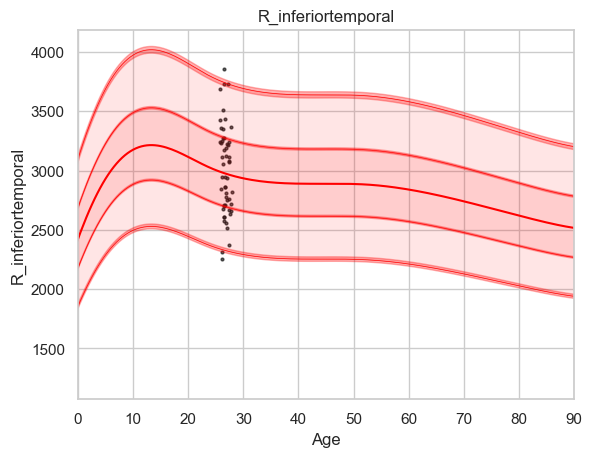

Running IDP 42 R_isthmuscingulate :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([217.54745992]), 'Rho': array([-0.2396221]), 'pRho': array([0.01844065]), 'SMSE': array([2.01661185]), 'EXPV': array([-0.36918387])}


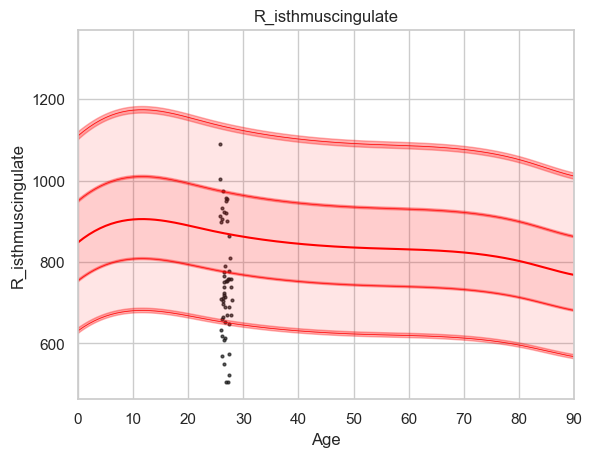

Running IDP 43 R_lateraloccipital :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([931.98104406]), 'Rho': array([-0.46674317]), 'pRho': array([1.06783999e-06]), 'SMSE': array([1.64945904]), 'EXPV': array([-0.64935182])}


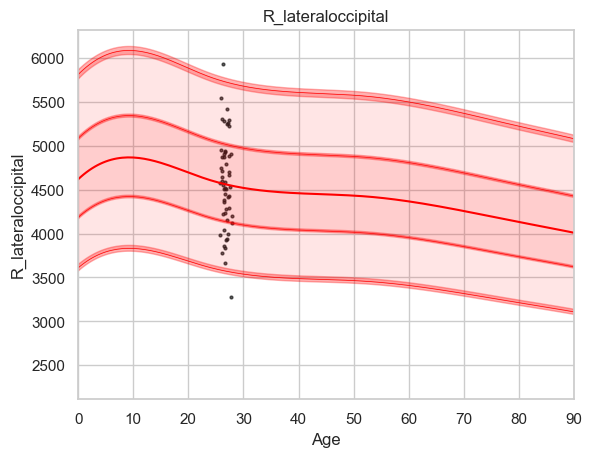

Running IDP 44 R_lateralorbitofrontal :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([448.91605346]), 'Rho': array([-0.25686701]), 'pRho': array([0.01128071]), 'SMSE': array([2.23066094]), 'EXPV': array([-0.61836872])}


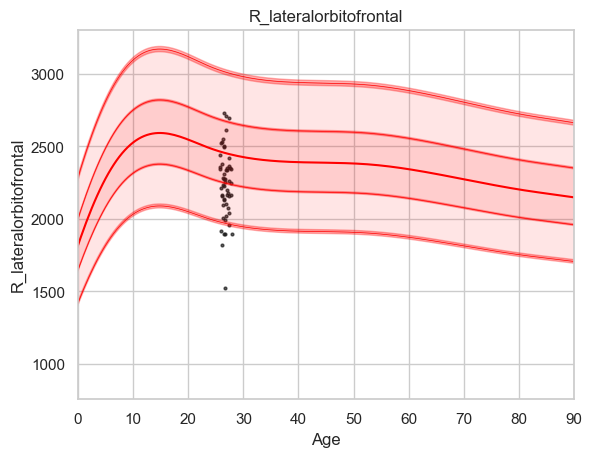

Running IDP 45 R_lingual :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([530.03455711]), 'Rho': array([-0.17859909]), 'pRho': array([0.08168027]), 'SMSE': array([1.25155832]), 'EXPV': array([-0.20073038])}


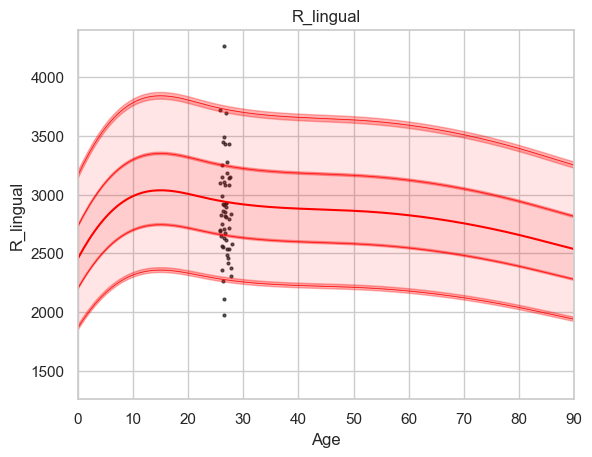

Running IDP 46 R_medialorbitofrontal :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([289.30258502]), 'Rho': array([-0.42701282]), 'pRho': array([1.08352481e-05]), 'SMSE': array([2.07466363]), 'EXPV': array([-0.80011938])}


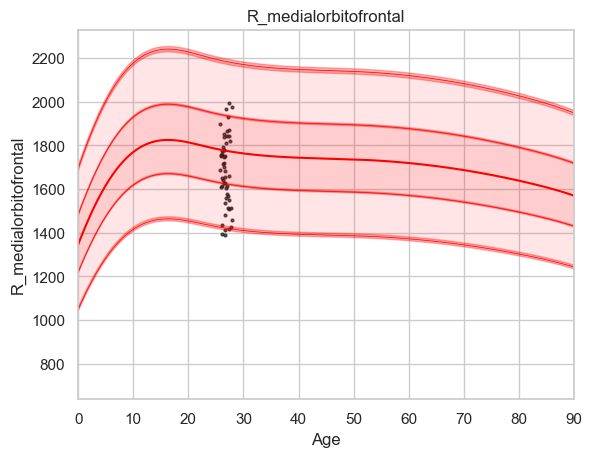

Running IDP 47 R_middletemporal :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([626.35169471]), 'Rho': array([-0.34976104]), 'pRho': array([0.00042897]), 'SMSE': array([1.93607571]), 'EXPV': array([-0.56056495])}


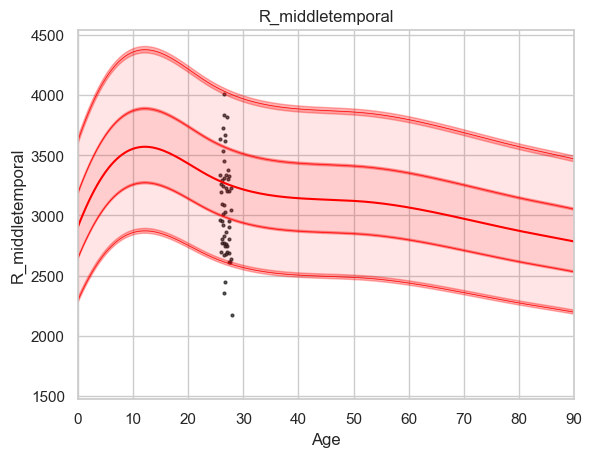

Running IDP 48 R_parahippocampal :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([115.61969173]), 'Rho': array([-0.18213057]), 'pRho': array([0.0756966]), 'SMSE': array([1.15839035]), 'EXPV': array([-0.14836747])}


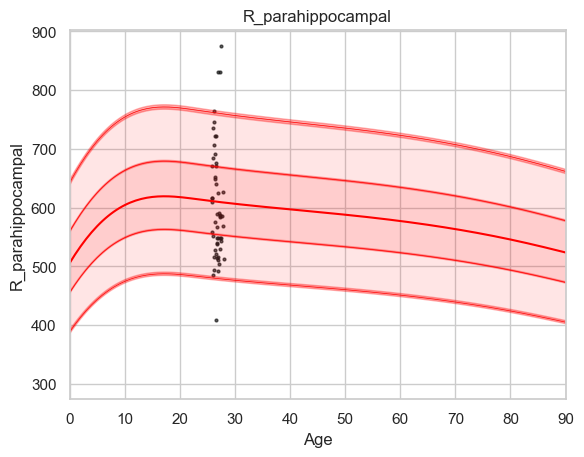

Running IDP 49 R_paracentral :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([268.90532266]), 'Rho': array([-0.3824404]), 'pRho': array([0.00010209]), 'SMSE': array([1.42672624]), 'EXPV': array([-0.3771701])}


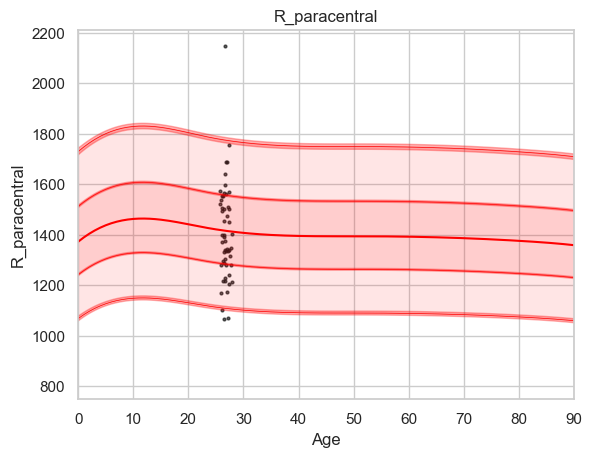

Running IDP 50 R_parsopercularis :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([270.33327219]), 'Rho': array([-0.27591259]), 'pRho': array([0.006303]), 'SMSE': array([1.19406014]), 'EXPV': array([-0.19321274])}


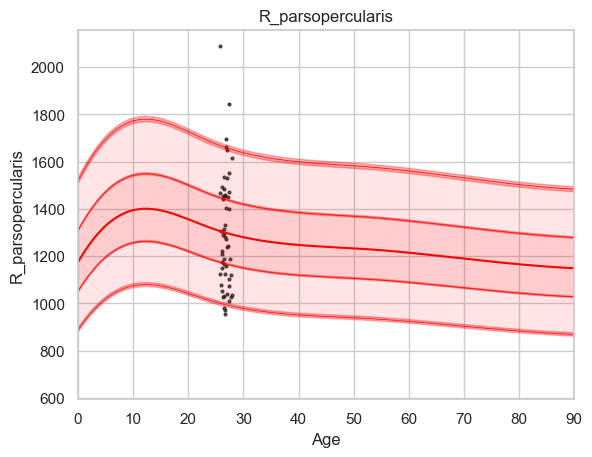

Running IDP 51 R_parsorbitalis :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([156.79647094]), 'Rho': array([-0.39276089]), 'pRho': array([6.26244952e-05]), 'SMSE': array([1.69461521]), 'EXPV': array([-0.55513282])}


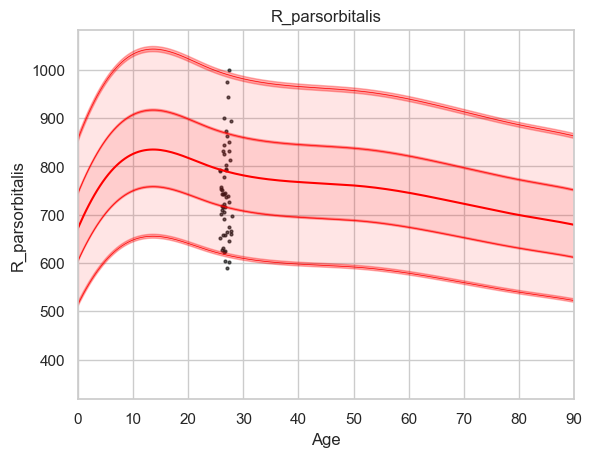

Running IDP 52 R_parstriangularis :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([295.59216442]), 'Rho': array([-0.19141051]), 'pRho': array([0.06163]), 'SMSE': array([1.5132705]), 'EXPV': array([-0.37926691])}


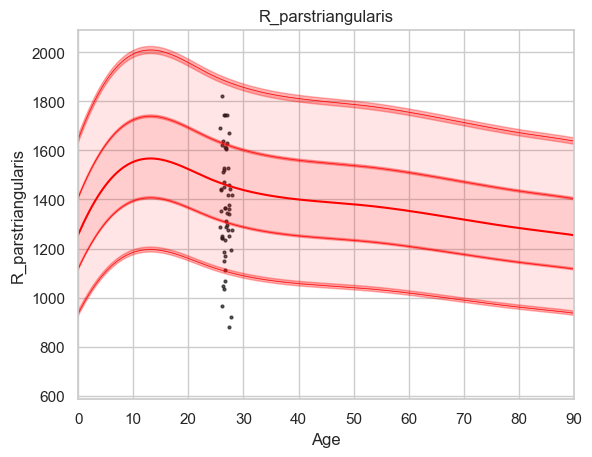

Running IDP 53 R_pericalcarine :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([315.87012273]), 'Rho': array([-0.17097839]), 'pRho': array([0.09587065]), 'SMSE': array([1.16138823]), 'EXPV': array([-0.13673333])}


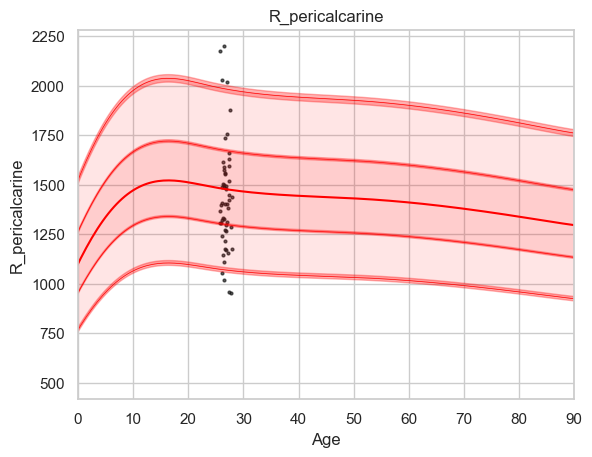

Running IDP 54 R_postcentral :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([650.2139899]), 'Rho': array([-0.46840332]), 'pRho': array([9.62298345e-07]), 'SMSE': array([1.66278415]), 'EXPV': array([-0.59448572])}


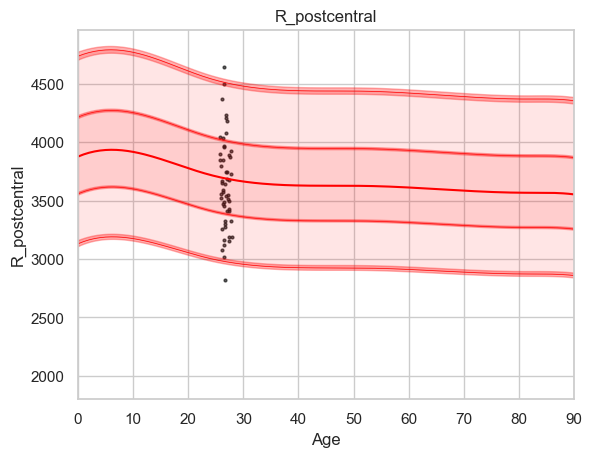

Running IDP 55 R_posteriorcingulate :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([257.54767586]), 'Rho': array([-0.23994298]), 'pRho': array([0.01827825]), 'SMSE': array([1.80777914]), 'EXPV': array([-0.30925306])}


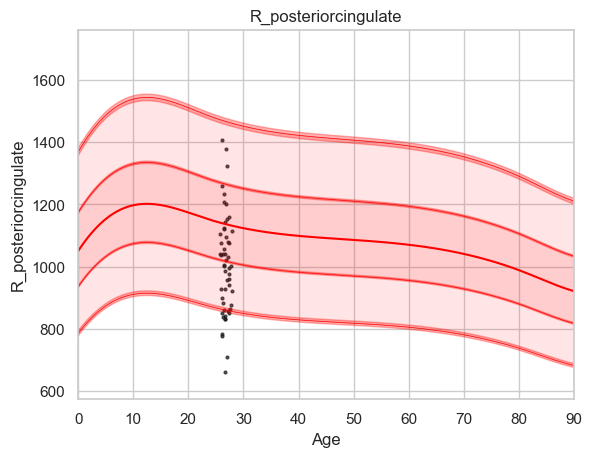

Running IDP 56 R_precentral :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([774.44542357]), 'Rho': array([-0.49577348]), 'pRho': array([1.57880968e-07]), 'SMSE': array([1.78833875]), 'EXPV': array([-0.64718088])}


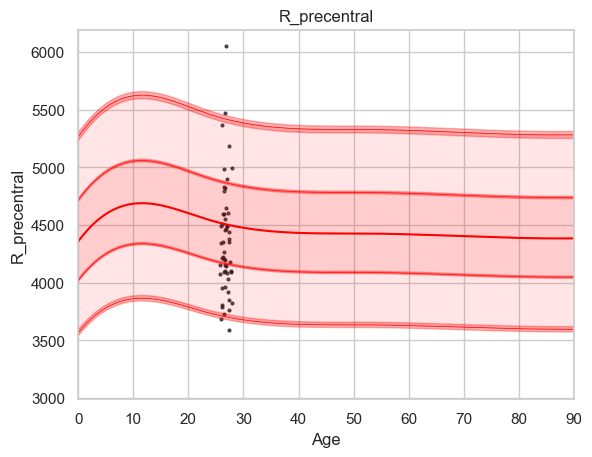

Running IDP 57 R_precuneus :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([678.70757654]), 'Rho': array([-0.55464939]), 'pRho': array([1.66028337e-09]), 'SMSE': array([1.89673269]), 'EXPV': array([-0.81380448])}


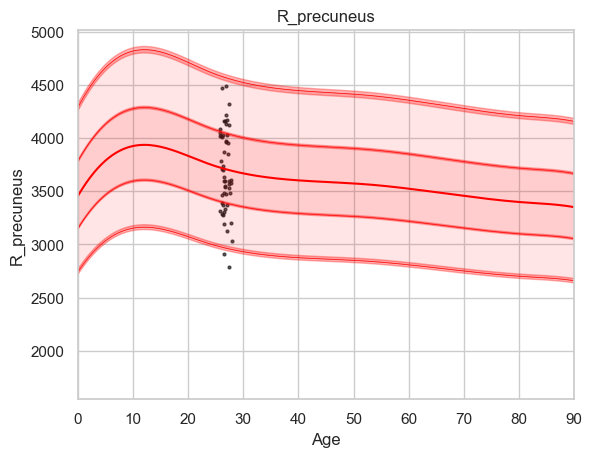

Running IDP 58 R_rostralanteriorcingulate :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([150.41445275]), 'Rho': array([-0.28154901]), 'pRho': array([0.00526231]), 'SMSE': array([1.6786929]), 'EXPV': array([-0.37728646])}


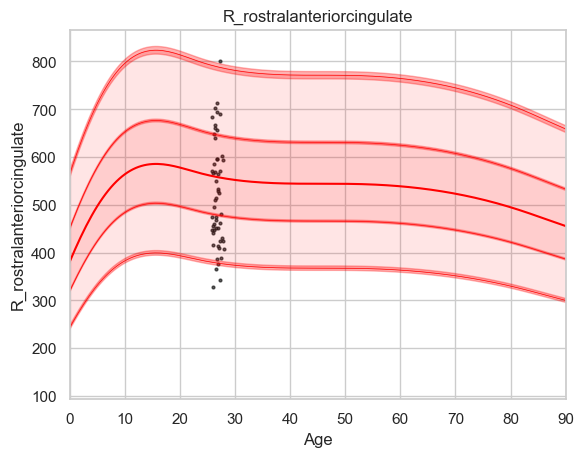

Running IDP 59 R_rostralmiddlefrontal :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([1140.36616024]), 'Rho': array([-0.36035147]), 'pRho': array([0.00027428]), 'SMSE': array([1.61309722]), 'EXPV': array([-0.60249031])}


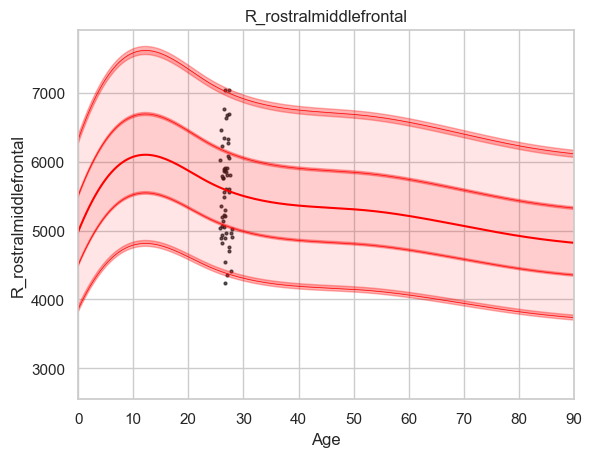

Running IDP 60 R_superiorfrontal :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([1192.4123731]), 'Rho': array([-0.4939524]), 'pRho': array([1.79052697e-07]), 'SMSE': array([1.85334302]), 'EXPV': array([-0.74180305])}


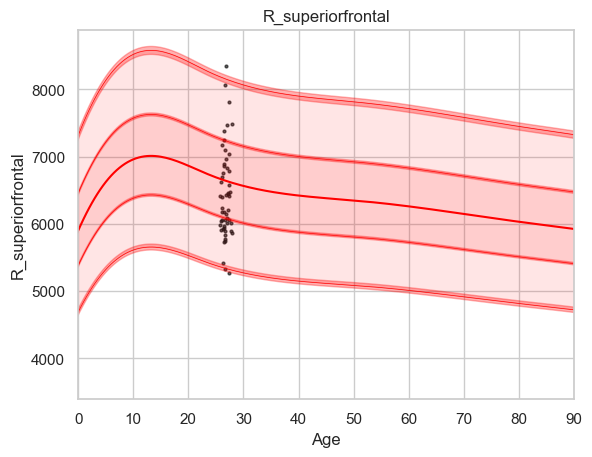

Running IDP 61 R_superiorparietal :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([825.6823593]), 'Rho': array([-0.52865946]), 'pRho': array([1.40159377e-08]), 'SMSE': array([1.72750994]), 'EXPV': array([-0.57795237])}


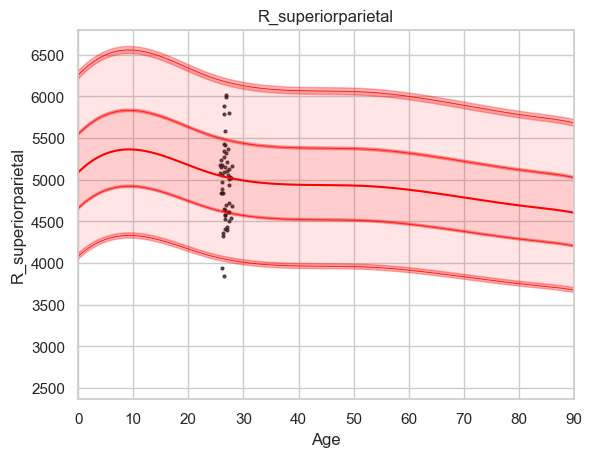

Running IDP 62 R_superiortemporal :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([543.36885543]), 'Rho': array([-0.2992274]), 'pRho': array([0.00291356]), 'SMSE': array([1.40031561]), 'EXPV': array([-0.38815824])}


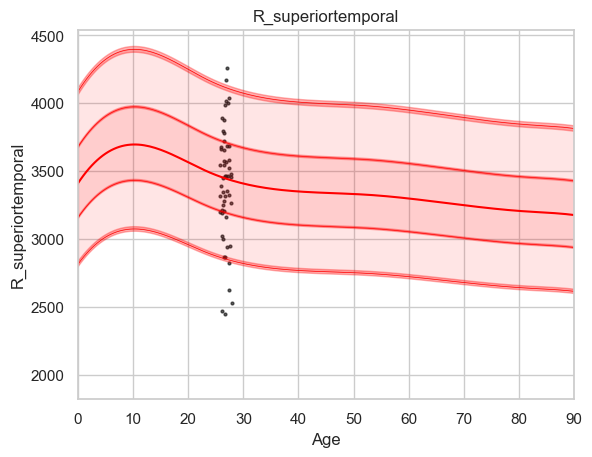

Running IDP 63 R_supramarginal :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([812.97005064]), 'Rho': array([-0.51796582]), 'pRho': array([3.18100242e-08]), 'SMSE': array([1.74354054]), 'EXPV': array([-0.59495263])}


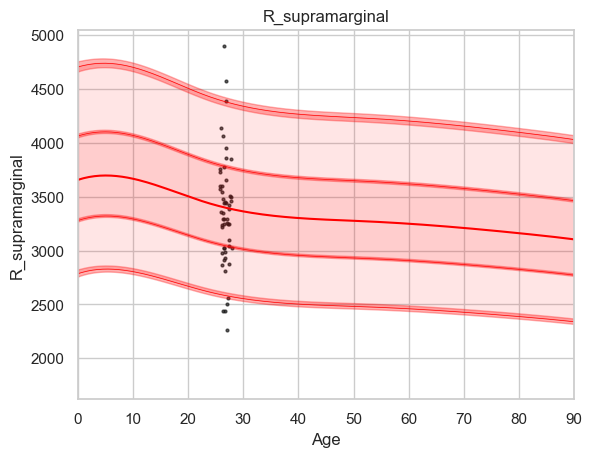

Running IDP 64 R_frontalpole :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([49.48052563]), 'Rho': array([-0.28525966]), 'pRho': array([0.00466308]), 'SMSE': array([1.3453707]), 'EXPV': array([-0.33066041])}


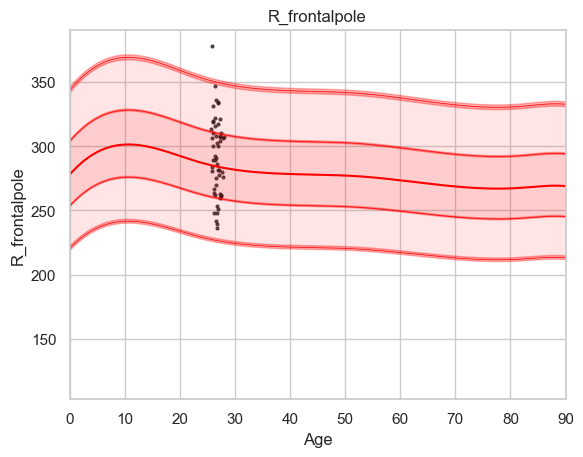

Running IDP 65 R_temporalpole :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([96.44713813]), 'Rho': array([-0.31402674]), 'pRho': array([0.00172295]), 'SMSE': array([1.22224027]), 'EXPV': array([-0.21049186])}


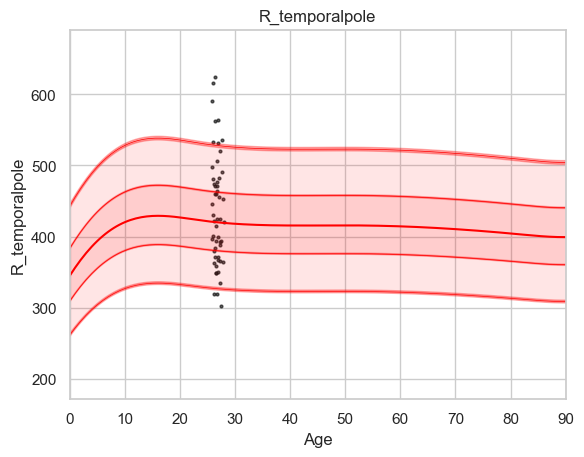

Running IDP 66 R_transversetemporal :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([57.38684736]), 'Rho': array([-0.33874556]), 'pRho': array([0.00067122]), 'SMSE': array([1.80108978]), 'EXPV': array([-0.41039403])}


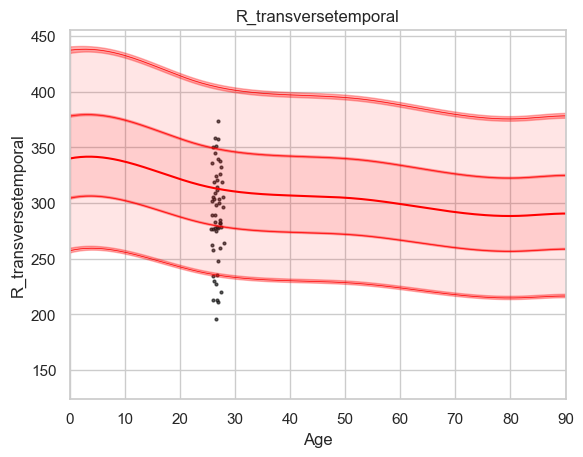

Running IDP 67 R_insula :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([361.00943148]), 'Rho': array([-0.39642509]), 'pRho': array([5.24237387e-05]), 'SMSE': array([1.7356628]), 'EXPV': array([-0.63489774])}


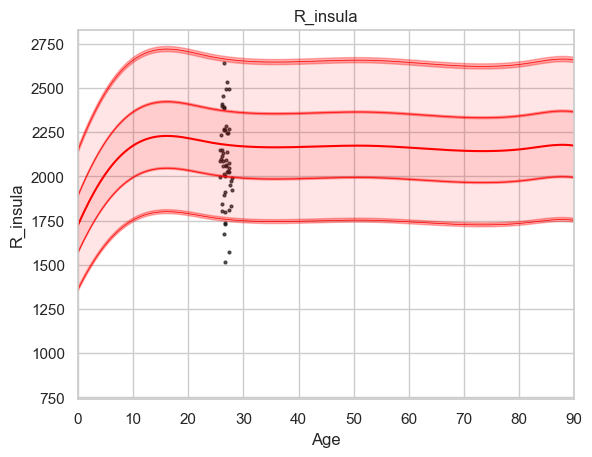

In [17]:
# plot the "test" (=preterm) data
sns.set(style='whitegrid')

for idp_num, idp in enumerate(idp_ids):
    print('Running IDP', idp_num, idp, ':')
    idp_dir = os.path.join(out_dir, idp)
    os.chdir(idp_dir)

    # load the true data points
    yhat_te = load_2d(os.path.join(idp_dir, 'yhat_predict.txt'))
    s2_te = load_2d(os.path.join(idp_dir, 'ys2_predict.txt'))
    y_te = load_2d(os.path.join(idp_dir, 'resp_te.txt'))

    # set up the covariates for the dummy data
    print('Making predictions with dummy covariates (for visualisation)')
    yhat, s2 = predict(cov_file_dummy,
                        alg = 'blr',
                        respfile = None,
                        model_path = os.path.join(idp_dir,'Models'),
                        outputsuffix = '_dummy')

    # load the normative model
    with open(os.path.join(idp_dir,'Models', 'NM_0_0_estimate.pkl'), 'rb') as handle:
        nm = pickle.load(handle)

    # get the warp and warp parameters
    W = nm.blr.warp
    warp_param = nm.blr.hyp[1:nm.blr.warp.get_n_params()+1]

    # first, we warp predictions for the true data and compute evaluation metrics
    med_te = W.warp_predictions(np.squeeze(yhat_te), np.squeeze(s2_te), warp_param)[0]
    med_te = med_te[:, np.newaxis]
    print('metrics:', evaluate(y_te, med_te))

    # then, we warp dummy predictions to create the plots
    med, pr_int = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2), warp_param)

    # extract the different variance components to visualise
    beta, junk1, junk2 = nm.blr._parse_hyps(nm.blr.hyp, X_dummy)
    s2n = 1/beta # variation (aleatoric uncertainty)
    s2s = s2-s2n # modelling uncertainty (epistemic uncertainty)

    # plot the data points
    y_te_rescaled_all = np.zeros_like(y_te)
    for sid, site in enumerate(site_ids_te):
        # plot the true test data points
        if all(elem in site_ids_tr for elem in site_ids_te):
            # all data in the test set are present in the training set

            # first, we select the data points belonging to this particular site
            idx = np.where(np.bitwise_and(X_te[:,2] == sex, X_te[:,sid+len(cols_cov)+1] !=0))[0]
            if len(idx) == 0:
                print('No data for site', sid, site, 'skipping...')
                continue

            # then directly adjust the data
            idx_dummy = np.bitwise_and(X_dummy[:,1] > X_te[idx,1].min(), X_dummy[:,1] < X_te[idx,1].max())
            y_te_rescaled = y_te[idx] - np.median(y_te[idx]) + np.median(med[idx_dummy])
        else:
            # we need to adjust the data based on the adaptation dataset

            # first, select the data point belonging to this particular site
            idx = np.where(np.bitwise_and(X_te[:,2] == sex, (df_te['site'] == site).to_numpy()))[0]

            # load the adaptation data
            y_ad = load_2d(os.path.join(idp_dir, 'resp_ad.txt'))
            X_ad = load_2d(os.path.join(idp_dir, 'cov_bspline_ad.txt'))
            idx_a = np.where(np.bitwise_and(X_ad[:,2] == sex, (df_ad['site'] == site).to_numpy()))[0]
            if len(idx) < 2 or len(idx_a) < 2:
                print('Insufficent data for site', sid, site, 'skipping...')
                continue

            # adjust and rescale the data
            y_te_rescaled, s2_rescaled = nm.blr.predict_and_adjust(nm.blr.hyp,
                                                                    X_ad[idx_a,:],
                                                                    np.squeeze(y_ad[idx_a]),
                                                                    Xs=None,
                                                                    ys=np.squeeze(y_te[idx]))
        # plot the (adjusted) data points
        plt.scatter(X_te[idx,1], y_te_rescaled, s=4, color='k', alpha = 0.7)

    # plot the median of the dummy data
    plt.plot(xx, med, clr)

    # fill the gaps in between the centiles
    junk, pr_int25 = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2), warp_param, percentiles=[0.25,0.75])
    junk, pr_int95 = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2), warp_param, percentiles=[0.05,0.95])
    plt.fill_between(xx, pr_int25[:,0], pr_int25[:,1], alpha = 0.1,color=clr)
    plt.fill_between(xx, pr_int95[:,0], pr_int95[:,1], alpha = 0.1,color=clr)

    # make the width of each centile proportional to the epistemic uncertainty
    junk, pr_int25l = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2-0.5*s2s), warp_param, percentiles=[0.25,0.75])
    junk, pr_int95l = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2-0.5*s2s), warp_param, percentiles=[0.05,0.95])
    junk, pr_int25u = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2+0.5*s2s), warp_param, percentiles=[0.25,0.75])
    junk, pr_int95u = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2+0.5*s2s), warp_param, percentiles=[0.05,0.95])
    plt.fill_between(xx, pr_int25l[:,0], pr_int25u[:,0], alpha = 0.3,color=clr)
    plt.fill_between(xx, pr_int95l[:,0], pr_int95u[:,0], alpha = 0.3,color=clr)
    plt.fill_between(xx, pr_int25l[:,1], pr_int25u[:,1], alpha = 0.3,color=clr)
    plt.fill_between(xx, pr_int95l[:,1], pr_int95u[:,1], alpha = 0.3,color=clr)

    # plot actual centile lines
    plt.plot(xx, pr_int25[:,0],color=clr, linewidth=0.5)
    plt.plot(xx, pr_int25[:,1],color=clr, linewidth=0.5)
    plt.plot(xx, pr_int95[:,0],color=clr, linewidth=0.5)
    plt.plot(xx, pr_int95[:,1],color=clr, linewidth=0.5)

    plt.xlabel('Age')
    plt.ylabel(idp)
    plt.title(idp)
    plt.xlim((0,90))
    plt.savefig(os.path.join(idp_dir, 'centiles_' + str(sex)),  bbox_inches='tight')
    plt.show()

os.chdir(out_dir)

# Spatial heterogeneity analysis

In [18]:
# load deviation scores 
extracted_zscores = {}

for idp in idp_ids:
    folder_path = join(mdl_dir, model_name, idp)
    z_predict_txt_path = os.path.join(folder_path, 'Z_adaptation.txt')
    
    # load z-scores for adaptation set
    df_name = f'df_Z_{idp}'
    extracted_zscores[df_name] = pd.read_csv(z_predict_txt_path, names=[f'Z_{idp}'])
    
# merge the extracted z-scores with the original data
for df_name, extracted_df in extracted_zscores.items():
    df_ad = pd.concat([df_ad, extracted_df], axis=1)

In [19]:
# load z-scores from model prediction: Z_application.txt in model folder (from application)
extracted_zscores = {}

for idp in idp_ids:
    folder_path = join(mdl_dir, model_name, idp)
    z_predict_txt_path = join(folder_path, 'Z_predict.txt')
    
    # load z-scores for application set
    df_name = f'df_Z_{idp}'
    extracted_zscores[df_name] = pd.read_csv(z_predict_txt_path, names=[f'Z_{idp}'])
    
# merge the extracted z-scores with the original data
for df_name, extracted_df in extracted_zscores.items():
    df_te = pd.concat([df_te, extracted_df], axis=1)


In [20]:
# combine all datasets
df_z = pd.concat([df_te, df_ad], axis=0)
df_z.reset_index(drop=True, inplace=True)
df_z.to_csv(os.path.join(out_dir_main, f'BLS-26_{brain_measure}_Z_scores.csv'), index=False)

## Percentages of deviations

In [21]:
# calculate percentage of deviating subjects
idp_ids_z = [f'Z_{idp}' for idp in idp_ids]
infra_supra_all = calc_infra_supra_percentage(idp_ids_z, ft_scores_df=df_ad, pt_scores_df=df_te, 
                                                infra_thr=-1.645, supra_thr=1.645)


In [22]:
# Ensure idp_order is correctly structured and passed to the function
idp_names = [i.split('_')[1] for i in idp_ids_lh]
# Alternatingly add L and R to the names
idp_order = [f'Z_{["L", "R"][i % 2]}_{idp_names[i // 2]}' for i in range(len(idp_names) * 2)]

### fullterm

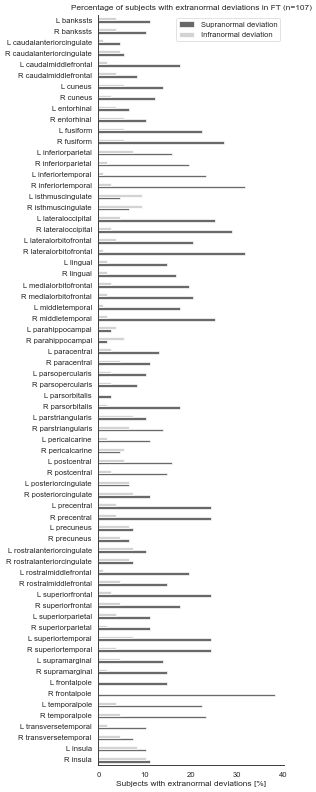

In [23]:
# Compute infranormal and supranormal deviations
z_scores_hc = df_ad.filter(like='Z_')
infranormal_hc = np.zeros([len(idp_order), 1])
supranormal_hc = np.zeros([len(idp_order), 1])

for i, idp in enumerate(idp_order):
    data = z_scores_hc[idp]
    infranormal_hc[i] = (data[data < -1.645].count()) / len(data) * 100
    supranormal_hc[i] = (data[data > 1.645].count()) / len(data) * 100

infra_all = pd.Series(data=infranormal_hc.flatten(), index=idp_order)
supra_all = pd.Series(data=supranormal_hc.flatten(), index=idp_order)

# Plot percentages of deviations in the test set
title = f'Percentage of subjects with extranormal deviations in FT (n={len(df_ad)})'
outname = join(out_dir_main, f"deviations_HC_{brain_measure}.svg")
df = plot_barplot(len(idp_order), supra_all, infra_all, 
                    idp_order, color_theme=['dimgray', 'lightgray'], title=title, outname=outname)

In [24]:
df.to_csv(join(out_dir_main, f"deviations_HC_{brain_measure}.csv"), index=False)

### preterm

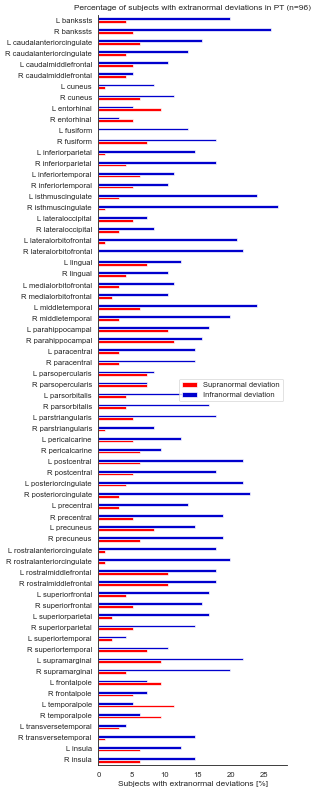

In [25]:
# Compute infranormal and supranormal deviations
z_scores_pt = df_te.filter(like='Z_')
infranormal_pt = np.zeros([len(idp_order), 1])
supranormal_pt = np.zeros([len(idp_order), 1])

for i, idp in enumerate(idp_order):
    data = z_scores_pt[idp]
    infranormal_pt[i] = (data[data < -1.645].count()) / len(data) * 100
    supranormal_pt[i] = (data[data > 1.645].count()) / len(data) * 100

infra_all = pd.Series(data=infranormal_pt.flatten(), index=idp_order)
supra_all = pd.Series(data=supranormal_pt.flatten(), index=idp_order)

# Plot percentages of deviations in the test set
title = f'Percentage of subjects with extranormal deviations in PT (n={len(df_te)})'
outname = join(out_dir_main, f"deviations_PT_{brain_measure}.svg")
df = plot_barplot(len(idp_order), supra_all, infra_all, 
                    idp_order, color_theme=['red','mediumblue'], title=title, outname=outname)

In [26]:
df.to_csv(join(out_dir_main, f"deviations_PT_{brain_measure}.csv"), index=False)